In [77]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import norm
import multiprocessing

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

import sys
sys.path.append(".")
from src.dc_smc import dc_smc 
from src.model import Model
from src.utils import resample

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 2-var model with updated samples

Target:
$$
y_i \sim \mathcal{N}(x_i, \sigma^2), i = 1, 2 \\
x_i \sim \mathcal{N}(x_3, \tau^2), i = 1, 2 \\
$$
Priors:
$$
x_i \sim \mathcal{N}(\mu_0, \sigma_0^2), i = 1, 2, 3
$$

In [137]:
tf.random.set_seed(2021)

N = 500 # num params samples
nobs = 1000 # num observations

sigma, tau = np.array([1.]), np.array([1.])
mu0, sigma0 = np.array([0.]), np.array([1.])

x3 = np.array([-2.]) 
x1, x2 = tfd.Normal(loc=x3, scale=tau).sample(2)
x_true = tf.reshape(tf.concat([x1, x2, x3], axis=0), (1, -1))


In [138]:
# simulate data
y1 = tfd.Normal(loc=x_true[:, 0], scale=sigma).sample((nobs, 1))
y2 = tfd.Normal(loc=x_true[:, 1], scale=sigma).sample((nobs, 1))
obs = tf.transpose(tf.concat([y1, y2], axis=1)[:, :, 0])

In [139]:
def init_target(obs):
    def log_gamma1(x):
        loglik = tfd.Normal(loc=x[:, :1], scale=sigma).log_prob(obs[:1, ])
        loglik = tf.reduce_sum(loglik, axis=1, keepdims=True)
        logprior = tfd.Normal(loc=mu0, scale=sigma0).log_prob(x[:, :1])
        return loglik + logprior

    def log_gamma2(x):
        loglik = tfd.Normal(loc=x[:, 1:2], scale=sigma).log_prob(obs[1:2, ])
        loglik = tf.reduce_sum(loglik, axis=1, keepdims=True)
        logprior = tfd.Normal(loc=mu0, scale=sigma0).log_prob(x[:, 1:2])
        return loglik + logprior

    def log_gamma3(x):
        loglik1 = tfd.Normal(loc=x[:, 0:1], scale=sigma).log_prob(obs[:1, ])
        loglik2 = tfd.Normal(loc=x[:, 1:2], scale=sigma).log_prob(obs[1:2, ])
        loglik = tf.reduce_sum(loglik1 + loglik2, axis=1, keepdims=True)

        logprior1 = tfd.Normal(loc=x[:, 2:3], scale=tau).log_prob(x[:, 0:1])
        logprior2 = tfd.Normal(loc=x[:, 2:3], scale=tau).log_prob(x[:, 1:2])
        logprior3 = tfd.Normal(loc=mu0, scale=sigma0).log_prob(x[:, 2:3])
        return loglik + logprior1 + logprior2 + logprior3
    
    def log_gamma2_new(x):
        loglik = tfd.Normal(loc=1 + x[:, 1:2], scale=sigma).log_prob(obs[1:2, ])
        loglik = tf.reduce_sum(loglik, axis=1, keepdims=True)
        logprior = tfd.Normal(loc=mu0, scale=sigma0).log_prob(x[:, 1:2])
        return loglik + logprior

    def log_gamma3_new(x):
        loglik1 = tfd.Normal(loc=x[:, 0:1], scale=sigma).log_prob(obs[:1, ])
        loglik2 = tfd.Normal(loc=1 + x[:, 1:2], scale=sigma).log_prob(obs[1:2, ])
        loglik = tf.reduce_sum(loglik1 + loglik2, axis=1, keepdims=True)

        logprior1 = tfd.Normal(loc=x[:, 2:3], scale=tau).log_prob(x[:, 0:1])
        logprior2 = tfd.Normal(loc=x[:, 2:3], scale=tau).log_prob(x[:, 1:2])
        logprior3 = tfd.Normal(loc=mu0, scale=sigma0).log_prob(x[:, 2:3])
        return loglik + logprior1 + logprior2 + logprior3
    
    return log_gamma1, log_gamma2, log_gamma3, log_gamma2_new, log_gamma3_new

In [140]:
class Proposal:
    def __init__(self):
        self.dist = tfd.Normal(np.zeros(1), np.ones(1))
    def log_prob(self, mu_new, mu_curr):
        return self.dist.log_prob(mu_new) # nsample x dim
    def sample(self, size, mu_curr):
        return self.dist.sample(size)[:, :, 0]

In [141]:
proposal = Proposal()
log_gamma1, log_gamma2, log_gamma3, _, _ = init_target(obs)

model = Model(log_gamma3, proposal, 2)
model.build_child(log_gamma1, proposal, 0)
model.build_child(log_gamma2, proposal, 1)

In [142]:
# samples_init = tf.zeros((N, x_true.shape[1]), dtype=tf.dtypes.float64)
samples_init = tfd.Normal(loc=np.zeros(1), scale=np.ones(1)).sample((N, x_true.shape[1]))[:, :, 0]
log_w_init = np.ones(samples_init.shape)

In [143]:
samples_res, log_w = dc_smc(samples_init, log_w_init, model)

In [144]:
samples_plot = samples_res.numpy()
samples_plot[:, -1] = resample(log_w, samples_res[:, -1])
samples_plot = tf.convert_to_tensor(samples_plot)

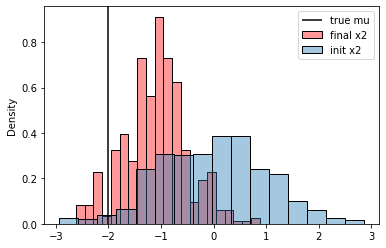

true x3: tf.Tensor(-2.0, shape=(), dtype=float64) 
estimate: tf.Tensor(-1.103186519491207, shape=(), dtype=float64)


In [145]:
ind = 2

sns.histplot(tf.reshape(samples_plot[:, ind], -1), stat="density", color="r", alpha=0.4, label=f"final x{ind}")
sns.histplot(tf.reshape(samples_init[:, ind], -1), stat="density", alpha=0.4, label=f"init x{ind}")
ymax = plt.ylim()[1]
plt.vlines(x_true[0, ind], 0, ymax, color="k", label="true mu")
plt.ylim(0, ymax)
x_plot = np.linspace(2, 4, 500)
plt.legend()
plt.show()

print(
    f"true x{ind+1}:",
    x_true[0, ind],
    "\nestimate:",
    tf.reduce_mean(samples_plot[:, ind])
)

### Update observations

In [146]:
# simulate data
y2_new = tfd.Normal(loc=1 + x_true[:, 1], scale=sigma).sample((nobs, 1))
obs_new = tf.transpose(tf.concat([y1, y2_new], axis=1)[:, :, 0])

In [147]:
proposal = Proposal()
log_gamma1, log_gamma2, log_gamma3, log_gamma2_new, log_gamma3_new = init_target(obs_new)

model = Model(log_gamma3_new, proposal, 2)
model.build_child(log_gamma1, proposal, 0, update=False)
model.build_child(log_gamma2_new, proposal, 1)

In [148]:
log_w_init = np.ones(samples_res.shape)

In [149]:
samples_res_new, log_w_new = dc_smc(samples_res, log_w_init, model)

In [150]:
samples_plot_new = samples_res_new.numpy()
samples_plot_new[:, -1] = resample(log_w_new, samples_res_new[:, -1])
samples_plot_new = tf.convert_to_tensor(samples_plot_new)

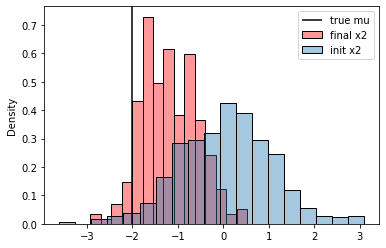

true x3: tf.Tensor(-2.0, shape=(), dtype=float64) 
estimate: tf.Tensor(-1.1902754667414137, shape=(), dtype=float64)


In [151]:
ind = 2

sns.histplot(tf.reshape(samples_plot_new[:, ind], -1), stat="density", color="r", alpha=0.4, label=f"final x{ind}")
sns.histplot(tf.reshape(samples_res[:, ind], -1), stat="density", alpha=0.4, label=f"init x{ind}")
ymax = plt.ylim()[1]
plt.vlines(x_true[0, ind], 0, ymax, color="k", label="true mu")
plt.ylim(0, ymax)
x_plot = np.linspace(2, 4, 500)
plt.legend()
plt.show()

print(
    f"true x{ind+1}:",
    x_true[0, ind],
    "\nestimate:",
    tf.reduce_mean(samples_plot_new[:, ind])
)

# 5-var model

Target:
$$
y_i | x_i \sim \mathcal{N}(x_i, \sigma^2), i = 1, 2, 3 \\
x_i | x_4 \sim \mathcal{N}(x_4, \tau^2), i = 1, 2 \\
x_i | x_5 \sim \mathcal{N}(x_t, \gamma^2), i = 3, 4
$$
Priors:
$$
x_i \sim \mathcal{N}(\mu_0, \sigma_0^2), i = 1, 2, \ldots, 5
$$

In [339]:
tf.random.set_seed(1)

N = 100 # num params samples
nobs = 500 # num observations

sigma, tau, gamma = np.array([1.]), np.array([1.]), np.array([1.])
mu0, sigma0 = np.array([0.]), np.array([1.])

x5 = np.array([-1.])
x4, x3 = tfd.Normal(loc=x5, scale=gamma).sample(2)
x1, x2 = tfd.Normal(loc=x4, scale=tau).sample(2)
x_true = tf.reshape(tf.concat([x1, x2, x3, x4, x5], axis=0), (1, -1))


In [340]:
# simulate data
y1 = tfd.Normal(loc=x_true[:, 0], scale=sigma).sample((nobs, 1))
y2 = tfd.Normal(loc=x_true[:, 1], scale=sigma).sample((nobs, 1))
y3 = tfd.Normal(loc=x_true[:, 2], scale=sigma).sample((nobs, 1))
obs = tf.transpose(tf.concat([y1, y2, y3], axis=1)[:, :, 0])

In [341]:
def log_gamma1(x):
    loglik = tfd.Normal(loc=x[:, :1], scale=sigma).log_prob(obs[:1, ])
    loglik = tf.reduce_sum(loglik, axis=1, keepdims=True)
    logprior = tfd.Normal(loc=mu0, scale=sigma0).log_prob(x[:, :1])
    return loglik + logprior

def log_gamma2(x):
    loglik = tfd.Normal(loc=x[:, 1:2], scale=sigma).log_prob(obs[1:2, ])
    loglik = tf.reduce_sum(loglik, axis=1, keepdims=True)
    logprior = tfd.Normal(loc=mu0, scale=sigma0).log_prob(x[:, 1:2])
    return loglik + logprior

def log_gamma3(x):
    loglik = tfd.Normal(loc=x[:, 2:3], scale=sigma).log_prob(obs[2:3, ])
    loglik = tf.reduce_sum(loglik, axis=1, keepdims=True)
    logprior = tfd.Normal(loc=mu0, scale=sigma0).log_prob(x[:, 2:3])
    return loglik + logprior

def log_gamma4(x):
    loglik1 = tfd.Normal(loc=x[:, 0:1], scale=sigma).log_prob(obs[:1, ])
    loglik2 = tfd.Normal(loc=x[:, 1:2], scale=sigma).log_prob(obs[1:2, ])
    loglik = tf.reduce_sum(loglik1 + loglik2, axis=1, keepdims=True)
    logprior1 = tfd.Normal(loc=x[:, 3:4], scale=tau).log_prob(x[:, 0:1])
    logprior2 = tfd.Normal(loc=x[:, 3:4], scale=tau).log_prob(x[:, 1:2])
    logprior4 = tfd.Normal(loc=mu0, scale=sigma0).log_prob(x[:, 3:4])
    return loglik + logprior1 + logprior2 + logprior4

def log_gamma5(x):
    loglik1 = tfd.Normal(loc=x[:, 0:1], scale=sigma).log_prob(obs[:1, ])
    loglik2 = tfd.Normal(loc=x[:, 1:2], scale=sigma).log_prob(obs[1:2, ])
    loglik3 = tfd.Normal(loc=x[:, 2:3], scale=sigma).log_prob(obs[2:3, ])
    loglik = tf.reduce_sum(loglik1 + loglik2 + loglik3, axis=1, keepdims=True)
    logp1 = tfd.Normal(loc=x[:, 3:4], scale=tau).log_prob(x[:, 0:1])
    logp2 = tfd.Normal(loc=x[:, 3:4], scale=tau).log_prob(x[:, 1:2])   
    logp3 = tfd.Normal(loc=x[:, 4:5], scale=sigma0).log_prob(x[:, 2:3])
    logp4 = tfd.Normal(loc=x[:, 4:5], scale=sigma0).log_prob(x[:, 3:4])
    logprior5 = tfd.Normal(loc=mu0, scale=sigma0).log_prob(x[:, 4:5])
    return loglik + logp1 + logp2 + logp3 + logp4 + logprior5

In [342]:
class Proposal:
    def __init__(self):
        self.dist = tfd.Normal(np.zeros(1), np.ones(1))
    def log_prob(self, mu_new, mu_curr):
        return self.dist.log_prob(mu_new) # nsample x dim
    def sample(self, size, mu_curr):
        return self.dist.sample(size)[:, :, 0]

In [343]:
model = Model(log_gamma5, proposal, 4)
model.build_left(log_gamma4, proposal, 3)
model.build_right(log_gamma3, proposal, 2)
model.left.build_left(log_gamma1, proposal, 0)
model.left.build_right(log_gamma2, proposal, 1)

In [344]:
samples_init = tfd.Normal(loc=np.zeros(1), scale=np.ones(1)).sample((N, x_true.shape[1]))[:, :, 0]
log_w_init = np.ones(samples_init.shape)

In [345]:
samples_res, log_w = dc_smc(samples_init, log_w_init, model)

In [346]:
samples_plot = samples_res.numpy()
samples_plot[:, -1] = resample(log_w, samples_res[:, -1])
samples_plot = tf.convert_to_tensor(samples_plot)

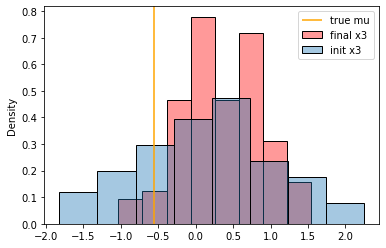

true x4: tf.Tensor(-0.5540992987520248, shape=(), dtype=float64) 
estimate: tf.Tensor(0.3465873554342571, shape=(), dtype=float64)


In [365]:
ind = 3

sns.histplot(tf.reshape(samples_plot[:, ind], -1), stat="density", color="r", alpha=0.4, label=f"final x{ind}")
sns.histplot(tf.reshape(samples_init[:, ind], -1), stat="density", alpha=0.4, label=f"init x{ind}")
ymax = plt.ylim()[1]
plt.vlines(x_true[0, ind], 0, ymax, color="orange", label="true mu")
plt.ylim(0, ymax)
x_plot = np.linspace(2, 4, 500)
# plt.plot(x_plot, posterior_den(x_plot, y), color="grey", label="true posterior")
plt.legend()
plt.show()

print(
    f"true x{ind+1}:",
    x_true[0, ind],
    "\nestimate:",
    tf.reduce_mean(samples_plot[:, ind])
)

### Compare with results from SMC

In [351]:
def loglik(x):
    loglik1 = tfd.Normal(loc=x[:, 0:1], scale=sigma).log_prob(obs[:1, ])
    loglik2 = tfd.Normal(loc=x[:, 1:2], scale=sigma).log_prob(obs[1:2, ])
    loglik3 = tfd.Normal(loc=x[:, 2:3], scale=sigma).log_prob(obs[2:3, ])
    loglik = tf.reduce_sum(loglik1 + loglik2 + loglik3, axis=1, keepdims=True)
    return loglik

def logprior(x):
    logp1 = tfd.Normal(loc=x[:, 3:4], scale=tau).log_prob(x[:, 0:1])
    logp2 = tfd.Normal(loc=x[:, 3:4], scale=tau).log_prob(x[:, 1:2])   
    logp3 = tfd.Normal(loc=x[:, 4:5], scale=sigma0).log_prob(x[:, 2:3])
    logp4 = tfd.Normal(loc=x[:, 4:5], scale=sigma0).log_prob(x[:, 3:4])
    logprior5 = tfd.Normal(loc=mu0, scale=sigma0).log_prob(x[:, 4:5])
    return logp1 + logp2 + logp3 + logp4 + logprior5
    
def smc(seed):
    return tfp.experimental.mcmc.sample_sequential_monte_carlo(
        prior_log_prob_fn=logprior,
        likelihood_log_prob_fn=loglik,
        current_state=samples_init,
        seed=seed)[1]

In [352]:
smc_res = smc(seed=(12, 34))

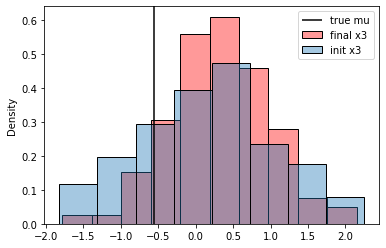

true x4: tf.Tensor(-0.5540992987520248, shape=(), dtype=float64) 
estimate: tf.Tensor(0.31870905059996657, shape=(), dtype=float64)


In [373]:
ind = 3

sns.histplot(tf.reshape(smc_res[:, ind], -1), stat="density", color="r", alpha=0.4, label=f"final x{ind}")
sns.histplot(tf.reshape(samples_init[:, ind], -1), stat="density", alpha=0.4, label=f"init x{ind}")
ymax = plt.ylim()[1]
plt.vlines(x_true[0, ind], 0, ymax, color="k", label="true mu")
plt.ylim(0, ymax)
x_plot = np.linspace(2, 4, 500)
plt.legend()
plt.show()

print(
    f"true x{ind+1}:",
    x_true[0, ind],
    "\nestimate:",
    tf.reduce_mean(smc_res[:, ind])
)